Dans ce notebook, nous entrainerons le modèle Unet, avec et sans data augmentation.

In [1]:
import pandas as pd
import numpy as np

import os, glob
import random
from time import time
import time

from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, concatenate, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model, load_model

from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose

from skimage.io import imshow

%matplotlib inline 

2022-10-11 03:55:13.194946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 03:55:13.733707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 03:55:13.733726: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-11 03:55:13.796429: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 03:55:15.047234: W tensorflow/stream_executor/platform/de

# Préparation des variables

In [2]:
model_path = 'data/model'
checkpoint_path = 'data/checkpoints'

train_input_dir = '../data/train/images'
train_target_dir = '../data/train/masks8'
val_input_dir = '../data/val/images'
val_target_dir = '../data/val/masks8'

IMG_WIDTH_HEIGHT = (256, 256)
IMG_CHANNELS = 3
batch_size = 7
n_classe = 8

In [4]:
df = pd.read_csv('data/comparatif.csv')
df

Model  Temps entrainement (minute)  Score_iou    Loss
0      FCN_adam_dice                      95.9579      26.43  0.2240
1  FCN_adam_dice_aug                     351.1985      25.63  0.2703

In [5]:
%%time
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(train_input_path), 
      ' - Number of target (8 categories): ', len(train_target_path))
print(train_input_path[0] + '\n')

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_target_path = sorted(glob.glob(val_target_dir +'/*.png'))
print('VAL -- Number of images: ', len(val_input_path), 
      ' - Number of target (8 categories): ', len(val_target_path))
print(val_input_path[0] + '\n')

TRAIN -- Number of images:  2380  - Number of target (8 categories):  2380
../data/train/images/aachen_000000_000019.png

VAL -- Number of images:  595  - Number of target (8 categories):  595
../data/val/images/stuttgart_000104_000019.png

CPU times: user 15.4 ms, sys: 1.35 ms, total: 16.7 ms
Wall time: 37.3 ms


# Data generator

In [6]:
class DataGenerator(Sequence):
    """Generate data for Keras
    """

    def __init__(self, input_path, target_path, IMG_WIDTH_HEIGHT, batch_size,
                 n_classes, shuffle):
        self.input_path = input_path
        self.target_path = target_path
        self.targetSize = IMG_WIDTH_HEIGHT
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    # ==== Définie le nombre de lots par époch ==== #
    # Si la longueur peut changer après la construction, l'utilisation 
    # de __len__ est plus approprié.
    # Sans cette fonction, impossible d'avoir len(trainGen).
    # Chaque appel demande un index de lot compris entre 0 et le nombre total 
    # de lots, ce dernier étant spécifié dans la méthode __len__.
    def __len__(self):
        return int(np.floor(len(self.input_path) / float(self.batch_size)))

    # la méthode on_epoch_end est déclenchée une fois au tout début ainsi 
    # qu'à la fin de chaque époque. Si le paramètre shuffle est défini sur 
    # True, nous obtiendrons un nouvel ordre d'exploration à chaque passage 
    # (ou conserverons simplement un schéma d'exploration linéaire dans le cas 
    # contraire).
    def on_epoch_end(self):
        # [0,1,2,3,4... nb_image]
        self.indexes = np.arange(len(self.input_path))

        # [2,4,1,3,0... nb_image]
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    # ==== Obtiens les lots d'images et masques ==== #
    # lorsque le batch correspondant à un index donné est appelé, 
    # le générateur exécute la méthode __getitem__ pour le générer.
    def __getitem__(self, index):
        # Genere batch_size nombre d'ID de ligne DATA 
        currentBatchIdsRow = self.indexes[index * self.batch_size:(index + 1) *
                                          self.batch_size]

        batch_x, batch_y = [], []

        # Itère sur les index
        for i, rowId in enumerate(currentBatchIdsRow):
            # Charge l'image, définie la taille cible, converti en tableau, normalise
            image = img_to_array(
                load_img(f'{self.input_path[i]}',
                         target_size=IMG_WIDTH_HEIGHT)) / 255.
            batch_x.append(image)

            # Chargement du masque original, définition de la taille 
            # cible et conversion en tableau
            mask8 = img_to_array(
                load_img(f'{self.target_path[i]}',
                         color_mode="grayscale",
                         target_size=IMG_WIDTH_HEIGHT))
            
            # to_categorical pour convertir nos étiquettes 
            # numériques stockées dans y en une forme binaire (par exemple, 
            # dans un problème à 6 classes, la troisième étiquette correspond 
            # à [0 0 1 0 0 0]) adaptée à la classification.
            mask = to_categorical(mask8, self.n_classes)
            batch_y.append(mask)

        return np.array(batch_x), np.array(batch_y)

In [7]:
# Generate data
trainGen = DataGenerator(train_input_path, train_target_path, IMG_WIDTH_HEIGHT, 
                         batch_size, n_classe, shuffle=False)

valGen = DataGenerator(val_input_path, val_target_path, IMG_WIDTH_HEIGHT, 
                       batch_size, n_classe, shuffle=False)

# Initialisation du modèle

In [8]:
def convolutional_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)

    # Génère de l'oublie pour mieux apprendre
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    
    # Redimensionne l'image pour revoir les mêmes caractéristiques qu'il
    # met en commun
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    conv = BatchNormalization()(conv)
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    return conv

def unet_model(input_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, IMG_CHANNELS),
               n_filters=32,
               n_classes=8):

    inputs = Input(input_size)

    #contracting path
    cblock1 = convolutional_block(inputs, n_filters)
    cblock2 = convolutional_block(cblock1[0], 2 * n_filters)
    cblock3 = convolutional_block(cblock2[0], 4 * n_filters)
    cblock4 = convolutional_block(cblock3[0], 8 * n_filters, dropout_prob=0.2)
    cblock5 = convolutional_block(cblock4[0],
                                  16 * n_filters,
                                  dropout_prob=0.2,
                                  max_pooling=None)

    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1], 8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_classes,
                   1,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes,
                    kernel_size=1,
                    padding='same',
                    activation='softmax')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [9]:
%%time
unet = unet_model((IMG_WIDTH_HEIGHT[0], IMG_WIDTH_HEIGHT[1], IMG_CHANNELS), n_classes=n_classe)
unet.summary()

2022-10-11 03:55:43.914919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-11 03:55:43.915166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 03:55:43.915244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-11 03:55:43.915303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-11 03:55:43.915359: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 32  18464      ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d_1[0][0]']               
 alization)                     )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'batch_normalization[0][0]']    
                                                                                                  
 conv2d_16

# Entrainement du modèle

In [10]:
start = time.time()
EPOCHS = 10

unet.compile(optimizer="adam",
             loss='mse',
             metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=8)])

earlystopper = [
    ModelCheckpoint(filepath='data/checkpoints/Unet_adam_mse.h5',
                    save_best_only=True,
                    verbose=True),
    EarlyStopping(monitor='val_loss',
                  min_delta=0,
                  patience=3,
                  verbose=0,
                  mode='auto')
]

model_history = unet.fit(trainGen,
                         validation_data=valGen,
                         workers=8,
                         epochs=EPOCHS,
                         callbacks=[earlystopper])

end = time.time()

total_time_training = end - start
total_time_training = round(total_time_training / 60, 4)
print("Temps d'entrainement: " + str(total_time_training) + " secondes")

Epoch 1/10
340/340 [==============================] - ETA: 0s - loss: 0.0165 - one_hot_mean_io_u: 0.6253
Epoch 1: val_loss improved from inf to 0.07037, saving model to data/checkpoints/Unet_adam_mse.h5
340/340 [==============================] - 1138s 3s/step - loss: 0.0165 - one_hot_mean_io_u: 0.6253 - val_loss: 0.0704 - val_one_hot_mean_io_u: 0.3108
Epoch 2/10
340/340 [==============================] - ETA: 0s - loss: 0.0054 - one_hot_mean_io_u: 0.8452
Epoch 2: val_loss did not improve from 0.07037
340/340 [==============================] - 1201s 4s/step - loss: 0.0054 - one_hot_mean_io_u: 0.8452 - val_loss: 0.1723 - val_one_hot_mean_io_u: 0.0415
Epoch 3/10
340/340 [==============================] - ETA: 0s - loss: nan - one_hot_mean_io_u: 0.0542
Epoch 3: val_loss did not improve from 0.07037
340/340 [==============================] - 1156s 3s/step - loss: nan - one_hot_mean_io_u: 0.0542 - val_loss: nan - val_one_hot_mean_io_u: 0.0071
Epoch 4/10
340/340 [=============================

## Sauvegarde/chargement du modèle

In [11]:
unet.save('data/model/Unet_adam_mse.h5')

In [12]:
# unet = keras.models.load_model('data/model/Unet_adam_mse.h5')

## Chargement du checkpoint

In [13]:
%%time
# Charge le meilleurs score du modèle à partir du checkpoints
unet.load_weights('data/checkpoints/Unet_adam_mse.h5')

# Imprime le score du modèle
loss, iou = unet.evaluate(valGen, verbose=2)
print("Meilleurs score, iou: {:5.2f}%".format(100 * iou))

85/85 - 59s - loss: 0.0704 - one_hot_mean_io_u: 0.3108 - 59s/epoch - 700ms/step
Meilleurs score, iou: 31.08%
CPU times: user 6min 46s, sys: 15.2 s, total: 7min 1s
Wall time: 59.8 s


## Sauvegarde des stats du modèle

In [14]:
df_unet = pd.DataFrame({
    'Model': ["Unet_adam_mse"],
    "Temps entrainement (minute)": [total_time_training],
    "Score_iou": [float('{:5.2f}'.format(100 * iou))],
    "Loss": [round(loss, 4)]
})

df = pd.concat([df, df_unet], ignore_index=True, axis=0)

df

Model  Temps entrainement (minute)  Score_iou    Loss
0      FCN_adam_dice                      95.9579      26.43  0.2240
1  FCN_adam_dice_aug                     351.1985      25.63  0.2703
2      Unet_adam_mse                      77.0679      31.08  0.0704

## Prédiction

In [15]:
%%time
val_preds = unet.predict(valGen)

85/85 [==============================] - 59s 685ms/step


2022-10-11 05:14:47.618509: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1247805440 exceeds 10% of free system memory.


CPU times: user 6min 38s, sys: 21.5 s, total: 6min 59s
Wall time: 1min


# Visualisation

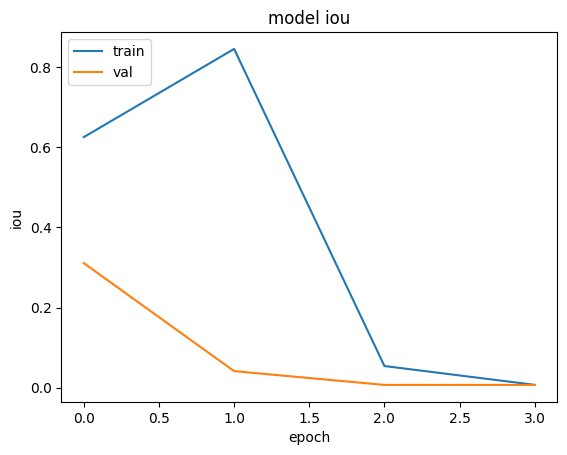

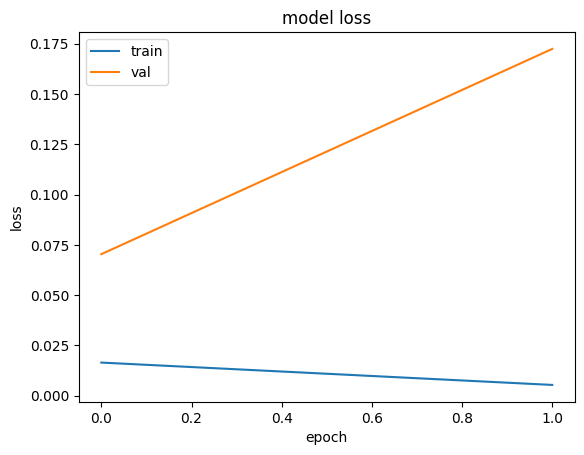

In [16]:
plt.plot(model_history.history['one_hot_mean_io_u'])
plt.plot(model_history.history['val_one_hot_mean_io_u'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

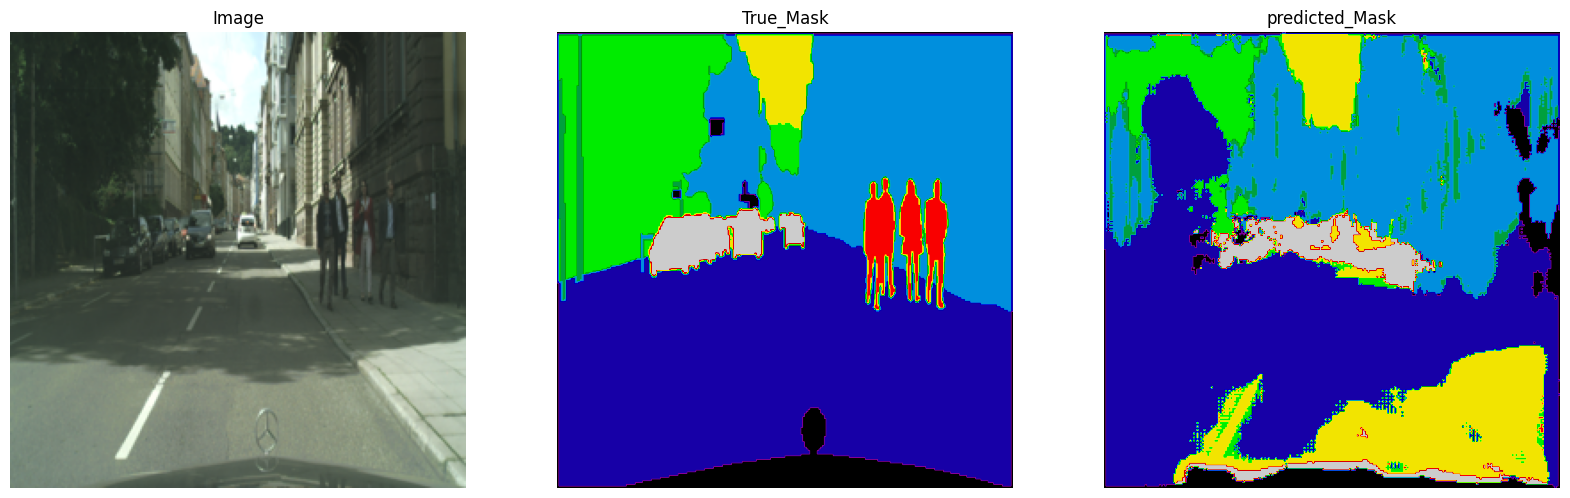

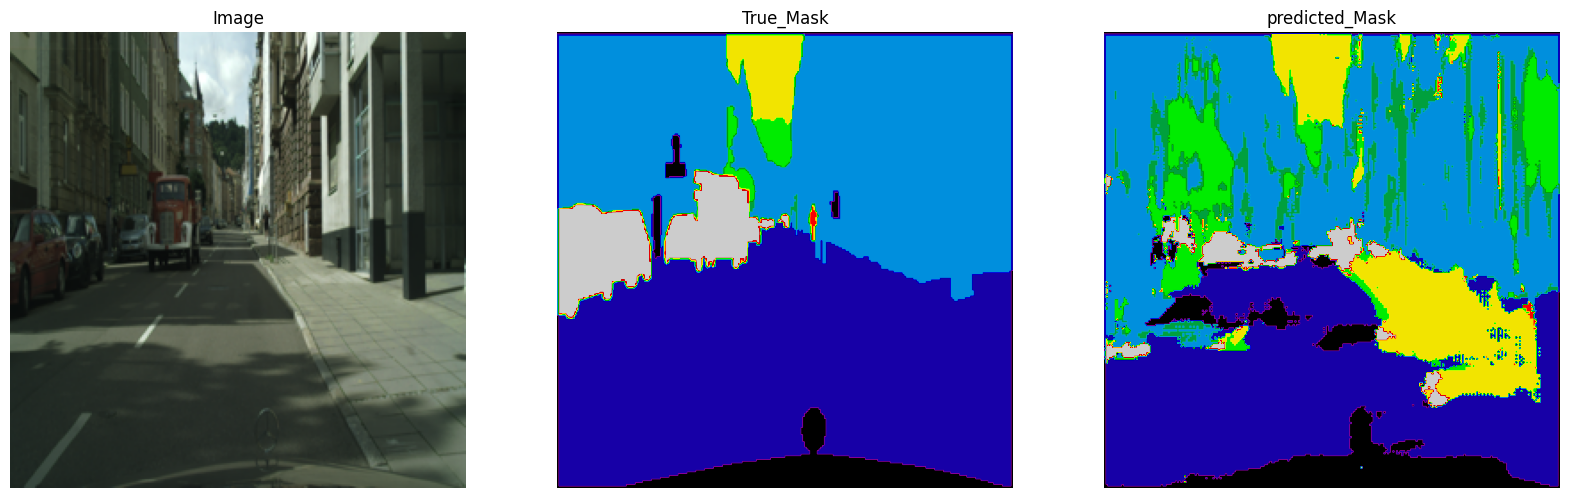

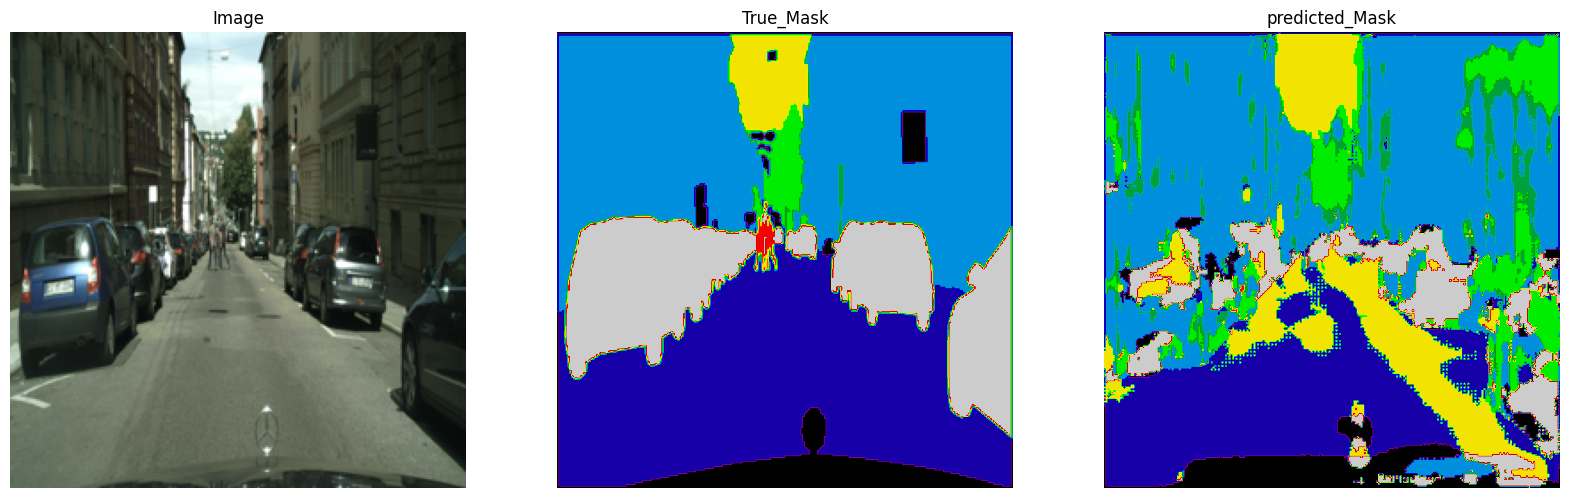

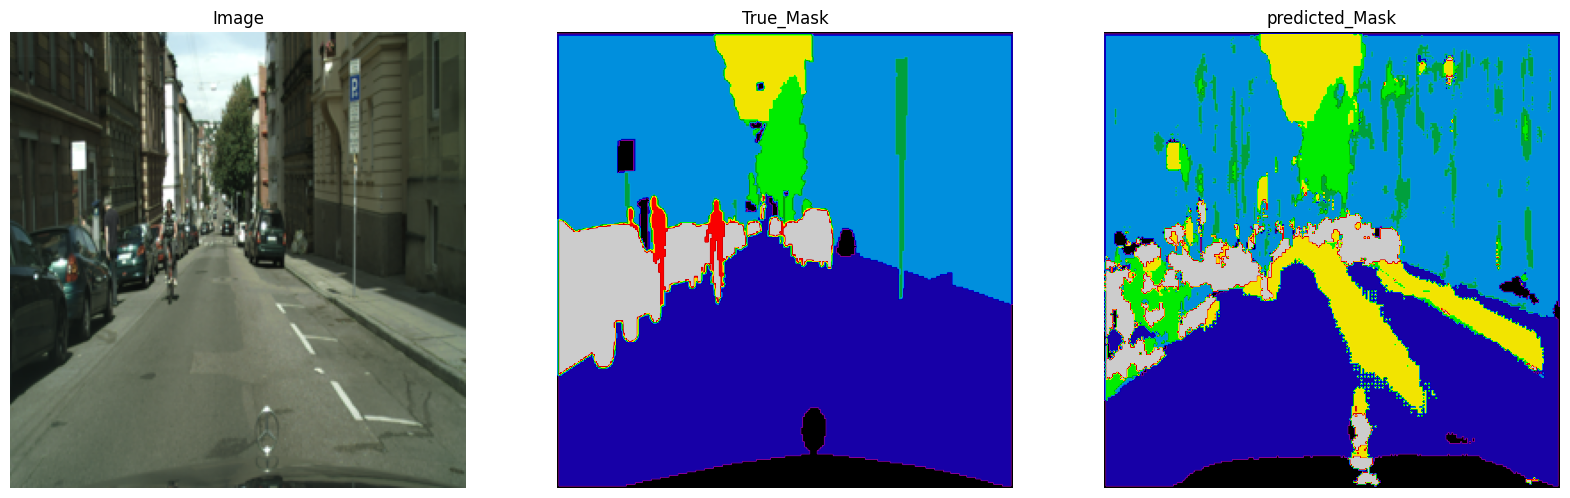

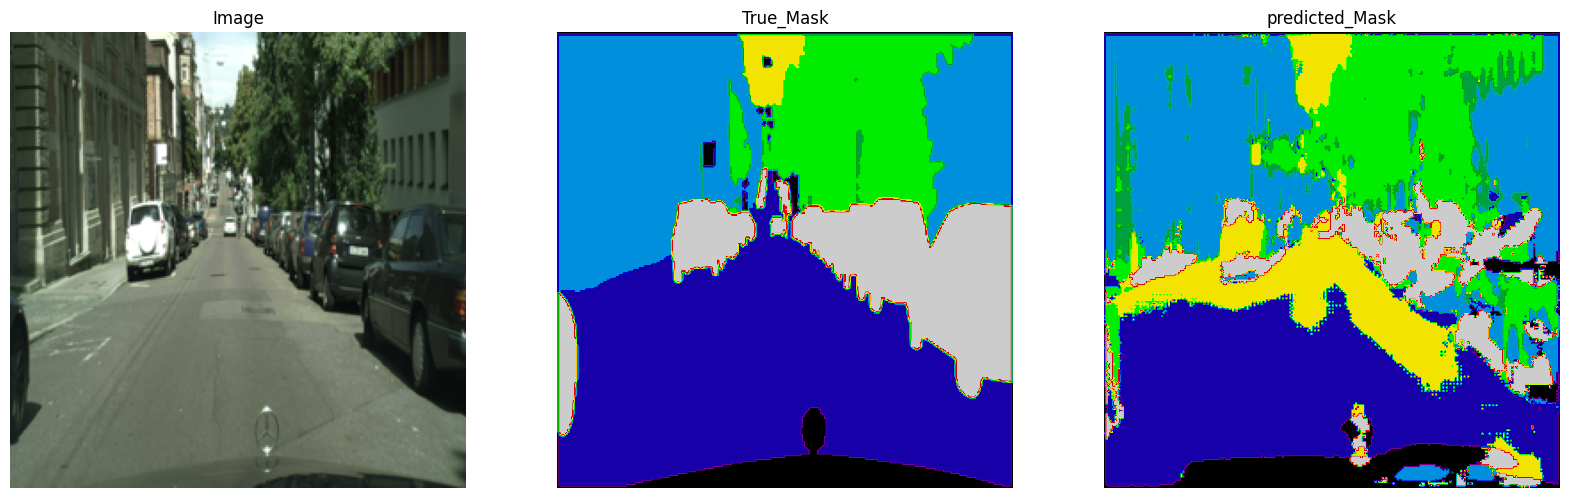

In [17]:
for i in range(0,5):
    image = img_to_array(load_img(f'{val_input_path[i]}'))/255.
    mask = img_to_array(load_img(f'{val_target_path[i]}', color_mode = "grayscale"))
    mask = np.squeeze(mask)
    pred_mask = np.argmax(val_preds[i], axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = np.squeeze(pred_mask)

    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Image')
    ax.imshow(image)
    ax.axis('off')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('True_Mask')
    ax2.imshow(mask, cmap='nipy_spectral')
    ax2.axis('off')

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.set_title('predicted_Mask')
    ax1.imshow(pred_mask, cmap='nipy_spectral')
    ax1.axis('off')

# Avec data augmentation

In [18]:
train_input_dir = '../data/train_augmentation/train/images'
train_target_dir = '../data/train_augmentation/train/masks8'

In [19]:
%%time
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))

CPU times: user 29.6 ms, sys: 503 µs, total: 30.1 ms
Wall time: 80.4 ms


In [20]:
trainGen = DataGenerator(train_input_path, train_target_path, IMG_WIDTH_HEIGHT, 
                         batch_size, n_classe, shuffle=False)

In [21]:
start = time.time()
EPOCHS = 10

unet.compile(optimizer="adam",
             loss='mse',
             metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=8)])

earlystopper = [
    ModelCheckpoint(filepath='data/checkpoints/Unet_adam_mse_aug.h5',
                    save_best_only=True,
                    verbose=True),
    EarlyStopping(monitor='val_loss',
                  min_delta=0,
                  patience=3,
                  verbose=0,
                  mode='auto')
]

model_history = unet.fit(trainGen,
                         validation_data=valGen,
                         workers=8,
                         epochs=EPOCHS,
                         callbacks=[earlystopper])

end = time.time()

total_time_training = end - start
total_time_training = round(total_time_training / 60, 4)
print("Temps d'entrainement: " + str(total_time_training) + " secondes")

Epoch 1/10
1360/1360 [==============================] - ETA: 0s - loss: 0.0035 - one_hot_mean_io_u_1: 0.8853
Epoch 1: val_loss improved from inf to 0.06569, saving model to data/checkpoints/Unet_adam_mse_aug.h5
1360/1360 [==============================] - 4600s 3s/step - loss: 0.0035 - one_hot_mean_io_u_1: 0.8853 - val_loss: 0.0657 - val_one_hot_mean_io_u_1: 0.3998
Epoch 2/10
1360/1360 [==============================] - ETA: 0s - loss: 0.0223 - one_hot_mean_io_u_1: 0.8235
Epoch 2: val_loss did not improve from 0.06569
1360/1360 [==============================] - 4605s 3s/step - loss: 0.0223 - one_hot_mean_io_u_1: 0.8235 - val_loss: 0.1728 - val_one_hot_mean_io_u_1: 0.0386
Epoch 3/10
1360/1360 [==============================] - ETA: 0s - loss: 0.0648 - one_hot_mean_io_u_1: 0.4229
Epoch 3: val_loss did not improve from 0.06569
1360/1360 [==============================] - 4493s 3s/step - loss: 0.0648 - one_hot_mean_io_u_1: 0.4229 - val_loss: 0.1096 - val_one_hot_mean_io_u_1: 0.2700
Epoch 

## Sauvegarde/chargement du modèle

In [22]:
unet.save('data/model/Unet_adam_mse_aug.h5')

In [23]:
# unet = keras.models.load_model('data/model/Unet_adam_mse_aug.h5')

## Chargement du checkpoint

In [24]:
%%time
# Charge le meilleurs score du modèle à partir du checkpoints
unet.load_weights('data/checkpoints/Unet_adam_mse_aug.h5')

# Imprime le score du modèle
loss, iou = unet.evaluate(valGen, verbose=2)
print("Meilleurs score, iou: {:5.2f}%".format(100 * iou))

85/85 - 69s - loss: 0.0657 - one_hot_mean_io_u_1: 0.3998 - 69s/epoch - 810ms/step
Meilleurs score, iou: 39.98%
CPU times: user 7min 35s, sys: 24.3 s, total: 7min 59s
Wall time: 1min 9s


## Sauvegarde des stats du modèle

In [25]:
df_unet_aug = pd.DataFrame({
    'Model': ["Unet_adam_mse_aug"],
    "Temps entrainement (minute)": [total_time_training],
    "Score_iou": [float('{:5.2f}'.format(100 * iou))],
    "Loss": [round(loss, 4)]
})

df = pd.concat([df, df_unet_aug], ignore_index=True, axis=0)

df

Model  Temps entrainement (minute)  Score_iou    Loss
0      FCN_adam_dice                      95.9579      26.43  0.2240
1  FCN_adam_dice_aug                     351.1985      25.63  0.2703
2      Unet_adam_mse                      77.0679      31.08  0.0704
3  Unet_adam_mse_aug                     315.1619      39.98  0.0657

In [26]:
df.to_csv (r'data/comparatif.csv', index = None, header=True)

## Prediction

In [27]:
%%time
val_preds = unet.predict(valGen)

85/85 [==============================] - 73s 849ms/step


2022-10-11 10:32:24.305191: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1247805440 exceeds 10% of free system memory.


CPU times: user 7min 55s, sys: 54.3 s, total: 8min 49s
Wall time: 1min 21s


## Visualisation

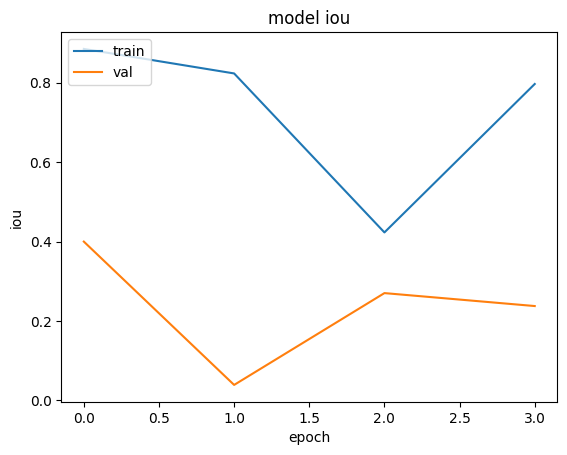

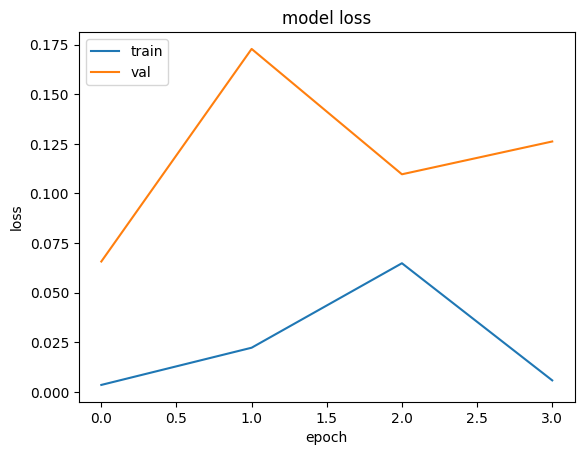

In [28]:
plt.plot(model_history.history['one_hot_mean_io_u_1'])
plt.plot(model_history.history['val_one_hot_mean_io_u_1'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

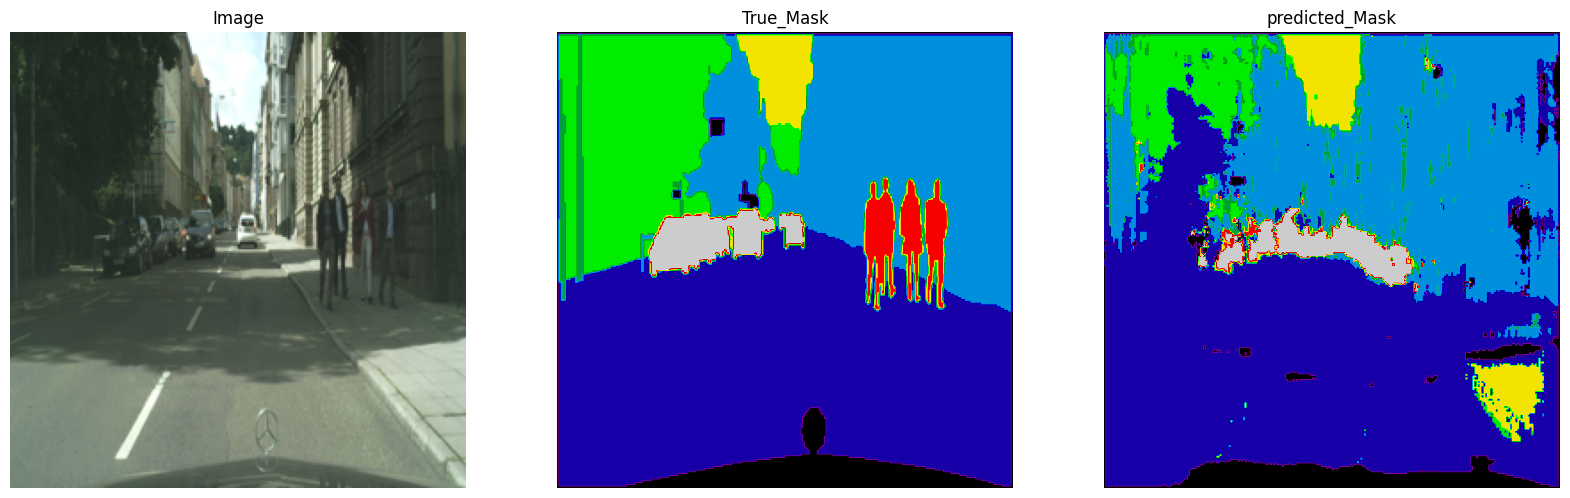

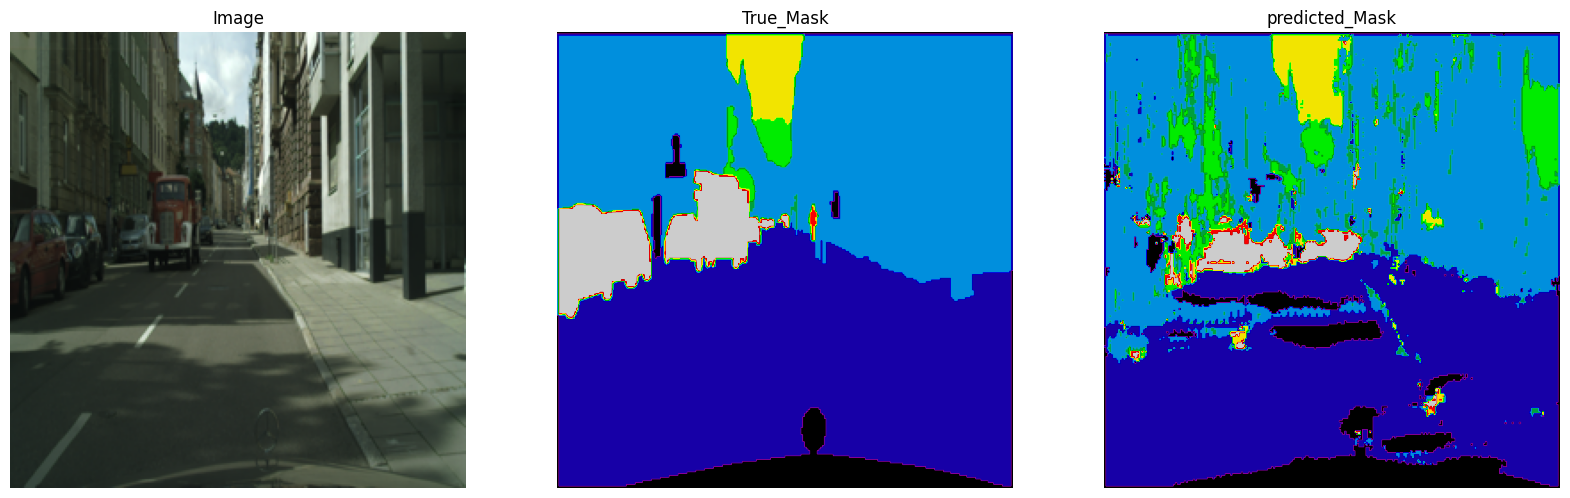

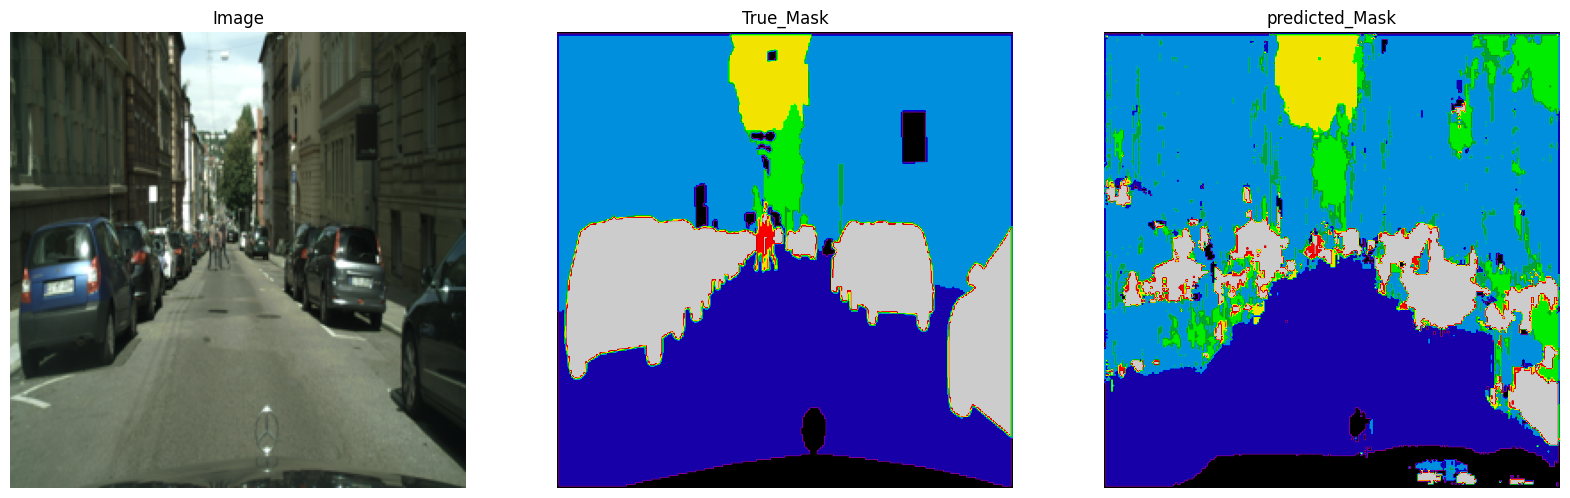

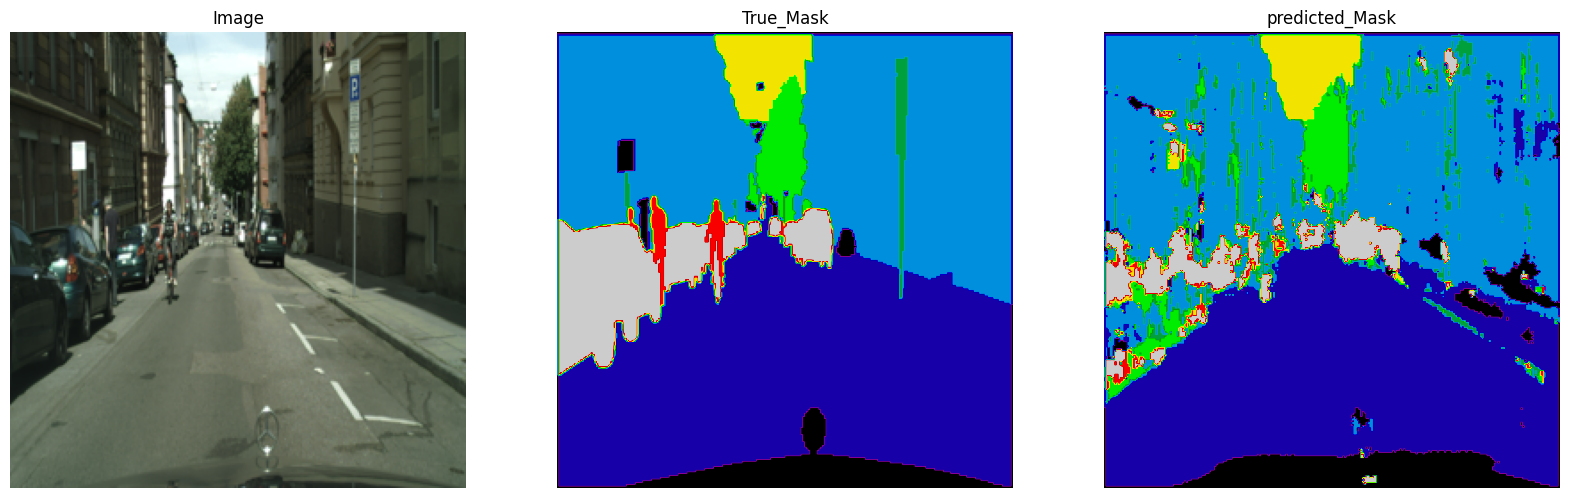

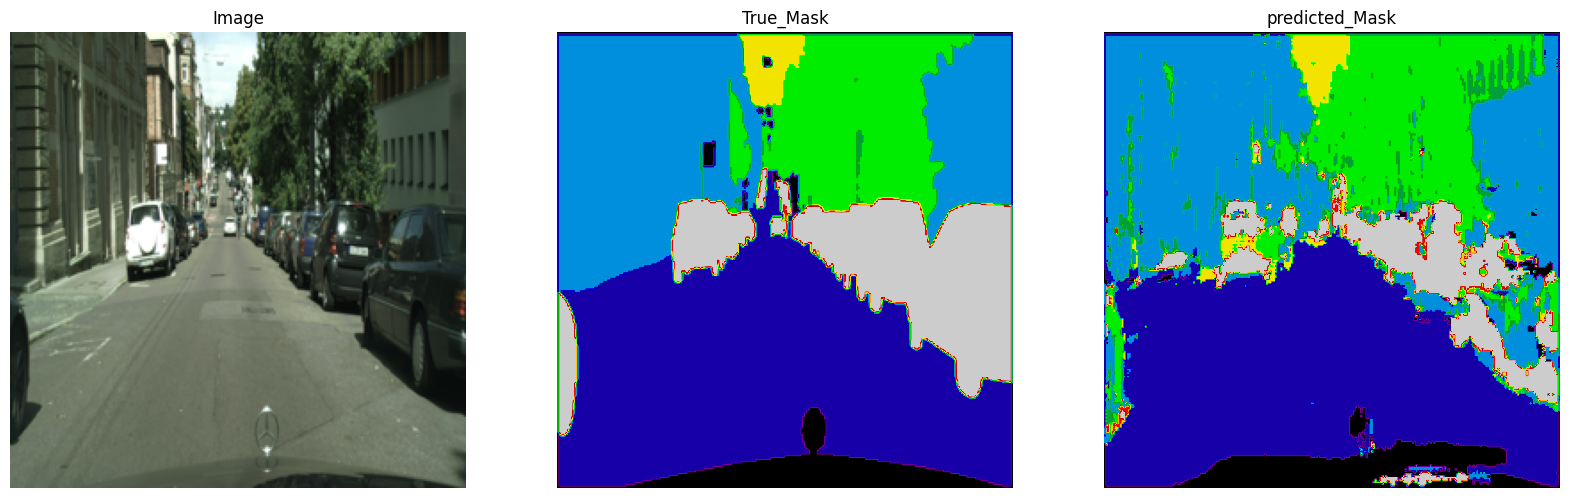

In [29]:
for i in range(0,5):
    image = img_to_array(load_img(f'{val_input_path[i]}'))/255.
    mask = img_to_array(load_img(f'{val_target_path[i]}', color_mode = "grayscale"))
    mask = np.squeeze(mask)
    pred_mask = np.argmax(val_preds[i], axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = np.squeeze(pred_mask)

    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Image')
    ax.imshow(image)
    ax.axis('off')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('True_Mask')
    ax2.imshow(mask, cmap='nipy_spectral')
    ax2.axis('off')

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.set_title('predicted_Mask')
    ax1.imshow(pred_mask, cmap='nipy_spectral')
    ax1.axis('off')

# Export du modele pour la production

## Chargement du modèle

In [30]:
unet = keras.models.load_model('data/model/Unet_adam_mse_aug.h5')

## Chargement du checkpoint

In [31]:
%%time
# Charge le meilleurs score du modèle à partir du checkpoints
unet.load_weights('data/checkpoints/Unet_adam_mse_aug.h5')

# Imprime le score du modèle
loss, iou = unet.evaluate(valGen, verbose=2)
print("Meilleurs score, iou: {:5.2f}%".format(100 * iou))

85/85 - 72s - loss: 0.0657 - one_hot_mean_io_u_1: 0.3998 - 72s/epoch - 843ms/step
Meilleurs score, iou: 39.98%
CPU times: user 7min 42s, sys: 28.9 s, total: 8min 11s
Wall time: 1min 11s


## Sauvegarde du checkpoint en tant que modèle final

In [32]:
unet.save('data/model/Unet_adam_mse_aug_final.h5')

In [33]:
unet = keras.models.load_model('data/model/Unet_adam_mse_aug_final.h5')

In [34]:
# Imprime le score du modèle
loss, iou = unet.evaluate(valGen, verbose=2)
print("Meilleurs score, iou: {:5.2f}%".format(100 * iou))

85/85 - 79s - loss: 0.0657 - one_hot_mean_io_u_1: 0.3998 - 79s/epoch - 933ms/step
Meilleurs score, iou: 39.98%
